<a href="https://colab.research.google.com/github/lucianosilva-github/supercomp/blob/master/MPI_AULA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MESSAGE PASSING INTERFACE (AULA 2)**

### **REDUÇÃO DISTRIBUÍDA DE PROCESSAMENTO**

Inicialmente, vamos reinstalar o simgrid e fazer o download do modelos de clusters:

In [ ]:
!apt install simgrid

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libsimgrid-dev' instead of 'simgrid'
The following additional packages will be installed:
  libsimgrid3.24 lua5.1 simgrid-java
Suggested packages:
  java-virtual-machine
The following NEW packages will be installed:
  libsimgrid-dev libsimgrid3.24 lua5.1 simgrid-java
0 upgraded, 4 newly installed, 0 to remove and 24 not upgraded.
Need to get 1,644 kB of archives.
After this operation, 5,797 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libsimgrid3.24 amd64 3.24+dfsg-3 [1,328 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 lua5.1 amd64 5.1.5-8.1build4 [94.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 simgrid-java amd64 3.24+dfsg-3 [76.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libsimgrid-dev amd64 3.24+dfsg-3 [145 kB]
Fetched 1,644 kB in 3s (587 kB/s)
Selecting p

In [ ]:
!git clone https://framagit.org/simgrid/simgrid-template-smpi.git

Cloning into 'simgrid-template-smpi'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (482/482), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 482 (delta 181), reused 434 (delta 139), pack-reused 0
Receiving objects: 100% (482/482), 967.28 KiB | 1.92 MiB/s, done.
Resolving deltas: 100% (181/181), done.


Na aula passada, implementamos um código para aproximação de PI usando MPI com 8 e 16 nodos de um cluster, utilizando as primitivas de comunicação MPI_Send e MPI_Recv.

In [ ]:
%%writefile pi_send_receive.c

#include <stdio.h>
#include <stdlib.h>
#include "mpi.h"
#include <math.h>
#define SEED_MPI 35791246
 
int main(int argc, char* argv[])
{
    long niter = 10000000;
    int myid;                       //holds process's rank id
    double x,y;                     //x,y value for the random coordinate
    int i, count=0;                 //Count holds all the number of how many good coordinates
    double z;                       //Used to check if x^2+y^2<=1
    double pi;                      //holds approx value of pi
    int nodenum;
 
    MPI_Init(&argc, &argv);                 //Start MPI
    MPI_Comm_rank(MPI_COMM_WORLD, &myid);           //get rank of node's process
    MPI_Comm_size(MPI_COMM_WORLD, &nodenum);
    int recieved[nodenum];
    long recvniter[nodenum];
    srand(SEED_MPI+myid);                       //Give rand() a seed value. Needs to be different on each node
 
    if(myid != 0)
    {
        for (i=0; i<niter; ++i)                  //main loop
        {
            x= ((double)rand())/RAND_MAX;           //gets a random x coordinate
            y =((double)rand())/RAND_MAX;           //gets a random y coordinate
            z = sqrt(x*x+y*y);                  //Checks to see if number in inside unit circle
            if (z<=1)
            {
                count++;                //if it is, consider it a valid random point
            }
        }
        for(i=0; i<nodenum; ++i) // we will simulate this program on a crossbar cluster.
                                 // See explanations in the text.
        {
           MPI_Send(&count,1,MPI_INT,0,1,MPI_COMM_WORLD);
           MPI_Send(&niter,1,MPI_LONG,0,2,MPI_COMM_WORLD);
        }
    }
    else if (myid == 0) //if the master process
    {
        for(i=0; i<nodenum; ++i)
        {
            MPI_Recv(&recieved[i],nodenum,MPI_INT,MPI_ANY_SOURCE,1,MPI_COMM_WORLD,MPI_STATUS_IGNORE);
            MPI_Recv(&recvniter[i],nodenum,MPI_LONG,MPI_ANY_SOURCE,2,MPI_COMM_WORLD,MPI_STATUS_IGNORE);
        }

        int finalcount = 0;
        long finalniter = 0;
        for(i = 0; i<nodenum; ++i)
        {
            finalcount += recieved[i];
            finalniter += recvniter[i];
        }
 
        pi = ((double)finalcount/(double)finalniter)*4.0;               //p = 4(m/n)
        printf("Pi: %f\n", pi);             //Print the calculated value of pi

    }
 
    MPI_Finalize();                     //Close the MPI instance
    return 0;
}

Overwriting pi_send_receive.c


Observe que, nesta solução, cada escravo está enviando um número de mensagens igual ao número de nós do cluster. Isto é necessário porque vamos simular a execução numa topologia de cluster do tipo crossbar:

https://simgrid.github.io/SMPI_CourseWare/topic_getting_started/platforms/

Nesta arquitetura, cada nó potencialmente pode ser um mestre e só vamos saber qual nó é o mestre no momento da execução. Se usássemos uma topologia do tipo estrela, com o mestre já conhecido, bastariam somente 2 mensagens de cada escravo.

Observe, também, que o mestre indica que pode receber mensagens de qualquer processo remoto pelo uso do parâmetro MPI_ANY_SOURCE.

Agora, vamos compilar e executar este programa no nosso cluster crossbar:

In [ ]:
!smpicc pi_send_receive.c -o pi_send_receive -lm

In [ ]:
!smpirun -np 16 -platform simgrid-template-smpi/cluster_crossbar.xml -hostfile simgrid-template-smpi/cluster_hostfile ./pi_send_receive

[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did not set the power of the host running the simulation.  The timings will certainly not be accurate.  Use the option "--cfg=smpi/host-speed:<flops>" to set its value.  Check https://simgrid.org/doc/latest/Configuring_SimGrid.html#automatic-benchmarking-of-smpi-code for more information.
Pi: 3.142268


Observe que todas as comunicações acima são do tipo ponto-a-ponto: cada processo-escravo envia mensagens diretamente para o nodo de rank 0 (mestre), informando a contagem de pontos que caíram dentro do quarto de círculo e o número de interações realizado. O mestre, então, recebe as mensagens de todos os escravos e sumariza os resultados. **Neste caso, dizemos que o mestre reduziu os dados coletados dos escravos**. 

### **MPI_REDUCE e MPI_ALLREDUCE**

**MPI_Reduce** é uma primitiva de comunicação MPI que coleta valores calculados por cada processo-escravo e os repassa para o processo-mestre para que possam ser reduzidos. A sintaxe de MPI_Reduce é mostrada abaixo:

**MPI_Reduce(
    void* send_data,
    void* recv_data,
    int count,
    MPI_Datatype datatype,
    MPI_Op op,
    int root,
    MPI_Comm communicator)**


O parâmetro send_data é um array de elementos do tipo datatype que cada processo deseja reduzir. O recv_data só é relevante no processo com rank root. A matriz recv_data contém o resultado reduzido e tem um tamanho de sizeof(datatype) * count. O parâmetro op é a operação que você deseja aplicar aos seus dados. O MPI contém um conjunto de operações de redução comuns que podem ser usadas. Embora as operações de redução personalizadas possam ser definidas, isso está além do escopo desta aula. As operações de redução definidas pela MPI incluem:

* **MPI_MAX** - Retorna o elemento máximo.
* **MPI_MIN** - Retorna o elemento mínimo.
* **MPI_SUM** - Soma os elementos.
* **MPI_PROD** - Multiplica todos os elementos.
* **MPI_LAND** - AND lógico entre os elementos.
* **MPI_LOR** - OR lógico entre os elementos.
* **MPI_BAND** - AND bit-a-bit dos elementos.
* **MPI_BOR** - OR bit-a-bit dos elementos.
* **MPI_MAXLOC** - Retorna o valor máximo e o rank do processo que o possui.
* **MPI_MINLOC** - Retorna o valor mínimo e o rank do processo que o possui.

Abaixo está uma ilustração do padrão de comunicação do MPI_Reduce para o operador de soma:

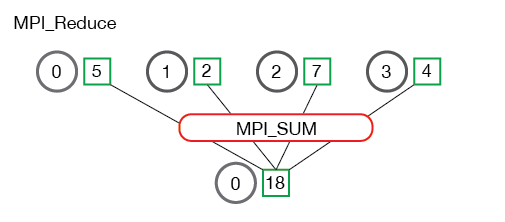

Também é útil ver o que acontece quando os processos contêm vários elementos. A ilustração abaixo mostra a redução de vários números por processo:

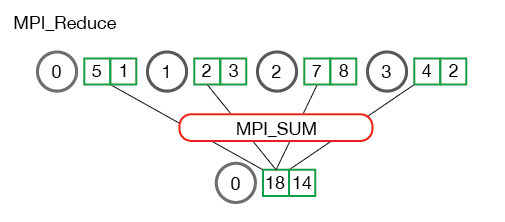

Cada um dos processos da ilustração acima tem dois elementos. A soma resultante ocorre por elemento. Em outras palavras, em vez de somar todos os elementos de todas as matrizes em um único elemento, o i-ésimo elemento de cada matriz é somado ao i-ésimo elemento na matriz de resultados do processo 0.

O trecho de código abaixo mostra como aplicar MPI_REDUCE para calcular uma média de valores produzidos por processos-escravos:

In [ ]:
%%writefile avg.c

#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>
#include <assert.h>
#include <time.h>

// Creates an array of random numbers. Each number has a value from 0 - 1
float *create_rand_nums(int num_elements) {
  float *rand_nums = (float *)malloc(sizeof(float) * num_elements);
  assert(rand_nums != NULL);
  int i;
  for (i = 0; i < num_elements; i++) {
    rand_nums[i] = (rand() / (float)RAND_MAX);
  }
  return rand_nums;
}

int main(int argc, char** argv) {
  if (argc != 2) {
    fprintf(stderr, "Usage: avg num_elements_per_proc\n");
    exit(1);
  }

  int num_elements_per_proc = atoi(argv[1]);

  MPI_Init(NULL, NULL);

  int world_rank;
  MPI_Comm_rank(MPI_COMM_WORLD, &world_rank);
  int world_size;
  MPI_Comm_size(MPI_COMM_WORLD, &world_size);

  // Create a random array of elements on all processes.
  srand(time(NULL)*world_rank);   // Seed the random number generator to get different results each time for each processor
  float *rand_nums = NULL;
  rand_nums = create_rand_nums(num_elements_per_proc);

  // Sum the numbers locally
  float local_sum = 0;
  int i;
  for (i = 0; i < num_elements_per_proc; i++) {
    local_sum += rand_nums[i];
  }

  // Print the random numbers on each process
  printf("Local sum for process %d - %f, avg = %f\n",
         world_rank, local_sum, local_sum / num_elements_per_proc);

  // Reduce all of the local sums into the global sum
  float global_sum;
  MPI_Reduce(&local_sum, &global_sum, 1, MPI_FLOAT, MPI_SUM, 0,
             MPI_COMM_WORLD);

  // Print the result
  if (world_rank == 0) {
    printf("Total sum = %f, avg = %f\n", global_sum,
           global_sum / (world_size * num_elements_per_proc));
  }

  // Clean up
  free(rand_nums);

  MPI_Barrier(MPI_COMM_WORLD);
  MPI_Finalize();
}

Writing avg.c


**EXERCÍCIO 1**

Compile e teste o programa acima. 

In [ ]:
!smpicc avg.c -o avg -lm

In [ ]:
!smpirun -np 16 -platform simgrid-template-smpi/cluster_crossbar.xml -hostfile simgrid-template-smpi/cluster_hostfile ./avg 100

[0.000000] [xbt_cfg/INFO] Configuration change: Set 'smpi/privatization' to '1'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'surf/precision' to '1e-9'
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'network/model' to 'SMPI'
[0.000000] [smpi_kernel/INFO] You did not set the power of the host running the simulation.  The timings will certainly not be accurate.  Use the option "--cfg=smpi/host-speed:<flops>" to set its value.  Check https://simgrid.org/doc/latest/Configuring_SimGrid.html#automatic-benchmarking-of-smpi-code for more information.
Local sum for process 0 - 54.682476, avg = 0.546825
Local sum for process 1 - 53.733265, avg = 0.537333
Local sum for process 2 - 50.004021, avg = 0.500040
Local sum for process 3 - 48.533802, avg = 0.485338
Local sum for process 4 - 53.392612, avg = 0.533926
Local sum for process 5 - 52.567123, avg = 0.525671
Local sum for process 6 - 46.119843, avg = 0.461198
Local sum for process 7 - 46.484497, avg = 0.464845
Local sum for process 8

Muitos aplicativos paralelos exigirão o acesso aos resultados reduzidos em todos os processos, em vez do processo-mestre. **MPI_Allreduce** é uma primitiva de comunicação MPI que reduzirá os valores e distribuirá os resultados para todos os processos. O protótipo da função é o seguinte:

**MPI_Allreduce(
    void* send_data,
    void* recv_data,
    int count,
    MPI_Datatype datatype,
    MPI_Op op,
    MPI_Comm communicator)**

Como você deve ter notado, MPI_Allreduce é idêntico a MPI_Reduce com a exceção de que não precisa de um ID de processo raiz (já que os resultados são distribuídos para todos os processos). A próxima imagem ilustra o padrão de comunicação de MPI_Allreduce:

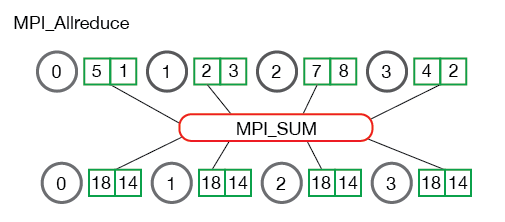

Muitos problemas computacionais requerem reduções múltiplas para resolver problemas. Um desses problemas é encontrar o desvio padrão de um conjunto distribuído de números. Para aqueles que podem ter esquecido, o desvio padrão é uma medida da dispersão dos números de sua média. Um desvio padrão mais baixo significa que os números estão mais próximos e vice-versa para desvios padrão mais altos.

Para encontrar o desvio padrão, deve-se primeiro calcular a média de todos os números. Depois que a média é calculada, as somas da diferença quadrada da média são calculadas. A raiz quadrada da média das somas é o resultado final. Dada a descrição do problema, sabemos que haverá pelo menos duas somas de todos os números, traduzindo-se em duas reduções.

O código para fazer isto encontra-se abaixo:

In [ ]:
#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>
#include <math.h>
#include <assert.h>

// Creates an array of random numbers. Each number has a value from 0 - 1

float *create_rand_nums(int num_elements) {
  float *rand_nums = (float *)malloc(sizeof(float) * num_elements);
  assert(rand_nums != NULL);
  int i;
  for (i = 0; i < num_elements; i++) {
    rand_nums[i] = (rand() / (float)RAND_MAX);
  }
  return rand_nums;
}

int main(int argc, char** argv) {
  if (argc != 2) {
    fprintf(stderr, "Usage: avg num_elements_per_proc\n");
    exit(1);
  }

  int num_elements_per_proc = atoi(argv[1]);

  MPI_Init(NULL, NULL);

  int world_rank;
  MPI_Comm_rank(MPI_COMM_WORLD, &world_rank);
  int world_size;
  MPI_Comm_size(MPI_COMM_WORLD, &world_size);

  // Create a random array of elements on all processes.
  srand(time(NULL)*world_rank); // Seed the random number generator of processes uniquely
  float *rand_nums = NULL;
  rand_nums = create_rand_nums(num_elements_per_proc);

  // Sum the numbers locally
  float local_sum = 0;
  int i;
  for (i = 0; i < num_elements_per_proc; i++) {
    local_sum += rand_nums[i];
  }

  // Reduce all of the local sums into the global sum in order to
  // calculate the mean
  float global_sum;
  MPI_Allreduce(&local_sum, &global_sum, 1, MPI_FLOAT, MPI_SUM,
                MPI_COMM_WORLD);
  float mean = global_sum / (num_elements_per_proc * world_size);

  // Compute the local sum of the squared differences from the mean
  float local_sq_diff = 0;
  for (i = 0; i < num_elements_per_proc; i++) {
    local_sq_diff += (rand_nums[i] - mean) * (rand_nums[i] - mean);
  }

  // Reduce the global sum of the squared differences to the root process
  // and print off the answer
  float global_sq_diff;
  MPI_Reduce(&local_sq_diff, &global_sq_diff, 1, MPI_FLOAT, MPI_SUM, 0,
             MPI_COMM_WORLD);

  // The standard deviation is the square root of the mean of the squared
  // differences.
  if (world_rank == 0) {
    float stddev = sqrt(global_sq_diff /
                        (num_elements_per_proc * world_size));
    printf("Mean - %f, Standard deviation = %f\n", mean, stddev);
  }

  // Clean up
  free(rand_nums);

  MPI_Barrier(MPI_COMM_WORLD);
  MPI_Finalize();
}

**EXERCÍCIO 2**

Compile e teste o programa acima. 

In [ ]:
#IMPLEMENTE SEU CÓDIGO AQUI

**EXERCÍCIO 3**

Refatore o código pi_send_receive.c para utilizar a primitiva MPI_Reduce ao invés de MPI_Send e MPI_Recv.

In [ ]:
#IMPLEMENTE SEU CÓDIGO AQUI

**EXERCÍCIO 4**

Refatore o código anterior produzindo um código paralelo híbrido:

*   O nodo-mestre calculará o números de pontos via OpenMP com 16 threads
*   Os resultados dos nodos-escravos serão coletados via MPI_Reduce e reduzidos no nodo-mestre.




In [ ]:
#IMPLEMENTE SEU CÓDIGO AQUI